In [1]:
import pandas as pd
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False)
from sklearn import neural_network as nn
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, KFold
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("Permuted Data")
df

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,Standardized_SMILES,pchembl_value,MolWt,LogP,QED
0,Brc1cncc(COCC2(c3ccccc3)CCNCC2)c1,4.82,361.283,3.6821,0.882288
1,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.70,397.526,6.4497,0.416926
2,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.47,398.514,4.8690,0.460447
3,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCOCC...,5.39,399.498,5.2960,0.490800
4,C1=NCCC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCC...,7.05,397.526,6.1021,0.438245
...,...,...,...,...,...
1257,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...,5.36,405.527,4.3692,0.472923
1258,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C24CC5CC...,6.30,456.634,5.7135,0.472659
1259,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2...,6.87,404.558,5.2934,0.555363
1260,c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCC...,6.72,397.526,5.4614,0.429771


In [2]:
# Generate Morgan Fingerprints
def generate_fingerprints(smiles, radius=2, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits))
    else:
        return np.zeros((nBits,))

df['Fingerprints'] = df['Standardized_SMILES'].apply(generate_fingerprints)

# Prepare features and target
X = np.array(list(df['Fingerprints']))
y = df['pchembl_value'].values

In [3]:
smiles = df['Standardized_SMILES'].values

In [4]:
MolWt = df['MolWt'].values
LogP = df['LogP'].values
QED=df['QED'].values

In [5]:
df

,Standardized_SMILES,pchembl_value,MolWt,LogP,QED,Fingerprints
0,Brc1cncc(COCC2(c3ccccc3)CCNCC2)c1,4.82,361.283,3.6821,0.882288,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.70,397.526,6.4497,0.416926,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCCCC...,6.47,398.514,4.8690,0.460447,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
3,C1=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCOCC...,5.39,399.498,5.2960,0.490800,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,C1=NCCC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCC...,7.05,397.526,6.1021,0.438245,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...
1257,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...,5.36,405.527,4.3692,0.472923,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1258,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C24CC5CC...,6.30,456.634,5.7135,0.472659,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1259,c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2...,6.87,404.558,5.2934,0.555363,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1260,c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCC...,6.72,397.526,5.4614,0.429771,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [6]:
#Now incorporate this sort of noise into df during the training

In [7]:
X.shape

(1262, 2048)

In [8]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from math import sqrt

def perform_fcv(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    rmse=list()
    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        model = nn.MLPRegressor(hidden_layer_sizes=(min(25,round(np.sqrt(X_train.shape[0])),)), random_state=42)
                                      
        X_test = X[start:stop]
        y_test = y[start:stop]
        smiles_test = smiles[start:stop]
        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]

        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        #print(discoveries.shape)
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        #print(discoveries.shape)
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions)))
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        print(trues)
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("unsorted_fcv_results_MLP_training batches.csv", index=False)
    test_df.to_csv("unsorted_fcv_results_MLP_testing batches.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })

    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

In [9]:

# Execute FCV sorted by target values (or another sorting metric if applicable)
results_df, false_disc, true_disc, true_ignore, false_ignore,rmse = perform_fcv(X, y, smiles, sort_by=None, additional_info=df["QED"])

/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.17538458444139635, 0.04949297533189405)
                                   Standardized_SMILES  actual  predictions
0    CC1CN(CCc2ccc([N+](=O)[O-])cc2)CCN1CCc1ccc([N+...   9.120     6.966876
4    CCC(CC)CN=c1c(C(N)=O)c(C)[nH]c2ccc(-c3cccnc3)cc12   6.170     5.227775
22   CCC(NC(=O)c1ccc(C#N)cc1)C1C2CC(n3cnc4cc(F)c(F)...   5.960     5.924756
23   CCC(NC(=O)c1ccc(C#N)cc1)C1C2CC(n3cnc4ccc(C#N)c...   5.920     5.613250
24   CCC(NC(=O)c1ccc(C#N)cc1)C1C2CC(n3cnc4ccc(Cl)cc...   6.300     6.189797
25   CCC(NC(=O)c1ccc(Cl)c(F)c1)C1C2CC(n3cnc4cc(F)c(...   5.600     5.669959
26   CCC(NC(=O)c1ccc(Cl)cc1)C1C2CC(n3c(C)nc4ccc(F)c...   5.690     5.567773
27   CCC(NC(=O)c1ccc(Cl)cc1)C1C2CC(n3cnc4c(F)cc(F)c...   5.720     5.535895
28   CCC(NC(=O)c1ccc(Cl)cc1)C1C2CC(n3cnc4c(F)cccc43...   6.000     6.020958
29   CCC(NC(=O)c1ccc(Cl)cc1)C1C2CC(n3cnc4cc(C#N)ccc...   6.820     6.023765
30   CCC(NC(=O)c1ccc(Cl)cc1)C1C2CC(n3cnc4cc(C#N)cnc...   6.160     6.183179
32   CCC(NC(=O)c1ccc(Cl)cc1)C1C2CC(n3cnc4cc(F

/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.5387052029848427, 7.677985923605405e-11)
                                   Standardized_SMILES  actual  predictions
0    CN(C(=O)Cc1ccc(-n2cnnn2)cc1)C1CCN(Cc2ccc(C(F)(...    5.92     5.498669
1    CN(C(=O)Cc1ccc(-n2cnnn2)cc1)C1CCN(Cc2ccc(C(F)(...    5.57     5.259753
7    CN(C(=O)Cc1ccc(-n2cnnn2)cc1)C1CCN(Cc2nc3cc(F)c...    5.89     6.142430
8    CN(C(=O)Cc1ccc(-n2cnnn2)cc1)C1CCN(Cc2nc3cc(F)c...    5.33     5.823416
9    CN(C(=O)Cc1ccc(S(C)(=O)=O)c(F)c1)C1CCN(Cc2ccc(...    5.54     5.809410
10   CN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(Cc2ccc(C(F...    5.52     5.531569
11   CN(C(=O)Cc1ccc(S(C)(=O)=O)cc1)C1CCN(Cc2ccc(C(F...    5.38     5.292652
14   CN(C(=O)Cc1ccc(S(C)(=O)=O)cc1F)C1CCN(Cc2ccc(C(...    5.58     6.324445
15     CN(C(=O)Cc1ccccc1)C1CCN(Cc2ccc(C(F)(F)F)cc2)CC1    5.80     5.377882
19           CN(C)Cc1ccc(C(F)(F)F)cc1Oc1ccc(Cl)c(Cl)c1    5.95     5.299016
22   CN(C)c1ccc2ncc(F)c(CCC34CCC(NCc5ccc6c(n5)NC(=O...    8.08     5.969780
23   CN(C)c1cnc2c(CCC34CCC(NCc5ccc6c(n5)NC(=

/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.5679634986831329, 4.037996150551105e-12)
                                   Standardized_SMILES  actual  predictions
0                          CNCc1ccc(Cl)cc1Oc1ccc(C)cc1    5.79     5.487532
1                      CNCc1ccc(Cl)cc1Oc1ccc(Cl)c(C)c1    5.75     5.513953
2                     CNCc1ccc(Cl)cc1Oc1ccc(Cl)c(Cl)c1    5.91     5.766963
3                      CNCc1ccc(Cl)cc1Oc1ccc(Cl)c(F)c1    5.91     5.851105
5                CNCc1ccc(Cl)cc1Oc1ccc(F)c(C(F)(F)F)c1    6.06     5.764348
6                       CNCc1ccc(Cl)cc1Oc1ccc(F)c(C)c1    5.52     5.237396
7                      CNCc1ccc(Cl)cc1Oc1ccc(F)c(Cl)c1    5.68     5.558874
8                         CNCc1ccc(Cl)cc1Oc1cccc(Cl)c1    5.68     5.333355
9                      CNCc1ccc(F)cc1Oc1ccc(Cl)c(Cl)c1    5.52     5.606707
10                    CNCc1ccc(OC)cc1Oc1ccc(Cl)c(Cl)c1    6.16     5.788857
11                        CNCc1ccccc1Oc1ccc(Cl)c(Cl)c1    5.41     5.492956
13      CNc1cc(CCN2CCN(CCc3ccc4c(c3)COC4=O)C

/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.8319404407291665, 1.6291632193486104e-33)
                                   Standardized_SMILES  actual  predictions
4    COc1cc(N2CCN(CCO)CC2)ccc1N=c1nc(-c2cnc3ccccn23...    5.43     5.977506
8    COc1cc(OC)c2nccc(CCC34CCC(NCc5ccc6c(n5)NC(=O)C...    8.75     7.941941
10   COc1cc(OC2CCNCC2)ccc1N=c1nc(-c2cnc3ccccn23)c(C...    5.32     6.285886
11   COc1cc(OC2CNC2)ccc1N=c1nc(-c2cnc3ccccn23)c(Cl)...    5.23     6.473442
12   COc1cc2c(cc1CCN1CCN(C(=O)Cc3ccc(-n4cnnn4)cc3)C...    5.25     5.259105
..                                                 ...     ...          ...
121  COc1nc2c(CCC34CCC(NCc5ccc6c(n5)NC(=O)CO6)(CC3)...    8.77     7.750663
122  COc1nc2c(CCC34CCC(NCc5ccc6c(n5)NC(=O)CO6)(CC3)...    9.14     7.262462
123  COc1nc2c(CCC34CCC(NCc5ccc6c(n5)NC(=O)CO6)(CC3)...    8.80     7.975835
124  COc1nc2c(CCC34CCC(NCc5ccc6c(n5)NC(=O)CO6)(CC3)...    8.38     7.919853
125  COc1nc2c(CCC34CCC(NCc5ccc6c(n5)NC(=O)CO6)(CC3)...    8.60     8.254014

[69 rows x 3 columns]


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7486959777235246, 6.887134542150408e-24)
                                   Standardized_SMILES  actual  predictions
0    COc1nc2ccc(Br)cc2cc1C(c1ccccc1)C(O)(CCN(C)C)c1...    5.80     5.265263
3    CS(=O)(=O)Cc1ccc(CN2C3CCC2CC(Oc2cccc(C(N)=O)c2...    8.18     7.164880
5    CS(=O)(=O)c1cc(CCN2CCN(CCc3ccc4c(c3)COC4=O)CC2...    5.33     5.311637
6    CS(=O)(=O)c1ccc(CCN2CCN(CCc3ccc([N+](=O)[O-])c...    6.82     7.062511
7       CSc1cc(CCN2CCN(CCc3ccc4c(c3)COC4=O)CC2)ccc1C#N    6.34     5.983532
..                                                 ...     ...          ...
112  Cc1ccc2c(-c3nnc(SCCN4CCc5cc6nc(C(F)(F)F)oc6c(C...    6.40     5.802808
116  Cc1ccc2nc3c(n2c1)CCN(CCCSc1nnc(-c2cccc4nc(C)cc...    5.60     5.585664
118  Cc1cccc(CCN2CCC(C(=O)c3ccc(NS(C)(=O)=O)cc3)CC2)n1    7.74     5.486516
119        Cc1cccc(CN2C3CCC2CC(Oc2cccc(C(N)=O)c2)C3)c1    9.28     6.977315
122  Cc1ccccc1-c1nc2cc(-c3ccc(Cl)cc3)sc2c(=O)n1CC1C...    5.68     5.312241

[77 rows x 3 columns]


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.8014242689319077, 1.854415158549923e-29)
                                   Standardized_SMILES  actual  predictions
1         Cc1ccccc1C(C)N1C2CCC1CC(Oc1cccc(C(N)=O)c1)C2    8.31     8.015350
2            Cc1ccccc1CN1C2CCC1CC(Oc1cccc(C(N)=O)c1)C2    9.21     8.875744
12   Cc1cccnc1CN1CCC2(CC1)C(=O)N(c1ccc(C3CCCCC3)cc1...    6.00     5.659564
14   Cc1ccn2c3c(nc2c1)CCN(CCCSc1nnc(-c2cccc4nc(C)cc...    6.60     5.910089
16   Cc1ccoc1-c1nnc(SCCCN2CC3CC3(c3ccc(C(F)(F)F)cc3...    6.70     6.048264
..                                                 ...     ...          ...
120  Cn1c(SCCCN2CC3CC3(c3ccc(C(F)(F)F)cc3)C2)nnc1-c...    6.20     6.415496
121  Cn1c(SCCCN2CC3CC3(c3ccc(C(F)(F)F)cc3)C2)nnc1-c...    5.40     6.233879
122  Cn1c(SCCCN2CC3CC3(c3ccc(C(F)(F)F)cc3)C2)nnc1-c...    5.50     6.301654
123  Cn1c(SCCCN2CCC3CC3(c3ccc(C(F)(F)F)cc3)CC2)nnc1...    5.30     6.681549
124  Cn1c(SCCCN2CCc3ccc4oc(C(F)(F)F)nc4c3CC2)nnc1-c...    6.60     5.876353

[77 rows x 3 columns]


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.5548819571288416, 1.561065124620967e-11)
                                   Standardized_SMILES  actual  predictions
2    Cn1cc(-c2ccc(OC3CCN(C(=O)Nc4ccc(OC(F)(F)F)cc4)...    5.42     5.318603
11   Cn1cnc(-c2cnc(OC3CCN(C(=O)Cc4ccc(OC(F)(F)F)cc4...    5.35     5.452066
15   FC(F)(F)Oc1ccc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)...    6.89     7.589323
16   FC(F)(F)Oc1cccc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45...    7.24     7.503594
23   FC(F)(F)c1ccc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C...    6.80     7.035385
25   FC1C=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCC...    6.77     6.924171
26   FC1C=NC(c2c[nH]c(-c3cc4c([nH]c5ccccc54)c(C4CCO...    5.76     6.074123
28   Fc1ccc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCOC...    6.20     6.378902
29   Fc1ccc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCOC...    6.42     6.615887
30   Fc1ccc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCOC...    6.46     6.544239
34   Fc1cccc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCO...    6.59     6.726911
35            Fc1cccc(C(Cc2ccccc2OC(F)(F)F)N

/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.8380877737793547, 1.975426015638965e-34)
                                   Standardized_SMILES  actual  predictions
19    NC(=O)c1c[nH]c2c(Cl)cc(-c3cccnc3)cc2c1=NC1CCOCC1    5.96     6.184232
21    NC(=O)c1c[nH]c2cc(Cl)c(-c3cccnc3)cc2c1=NC1CCOCC1    5.92     5.508152
22     NC(=O)c1c[nH]c2cc(F)c(-c3cccnc3)cc2c1=NC1CCOCC1    5.70     5.278453
24         NC(=O)c1c[nH]c2ccc(-c3cccnc3)cc2c1=NC1CCCC1    6.24     5.705071
25        NC(=O)c1c[nH]c2ccc(-c3cccnc3)cc2c1=NC1CCOCC1    5.68     5.532328
..                                                 ...     ...          ...
116  O=C(NCC1C2CC(n3cnc4cc(F)c(F)cc43)CC12)c1ccc(Cl...    5.32     6.143966
117     O=C(NCC1CCN(Cc2ccc(Br)nc2)CC1)c1cc(Cl)cc(Cl)c1    6.18     6.573108
118  O=C(NCC1CCN(Cc2cccc(C(F)(F)F)c2)CC1)c1cc(Cl)cc...    6.32     6.575840
120  O=C(Nc1ccc(C(F)(F)F)c(Cl)c1)N1CCN(CC2CCCN(C3CC...    6.05     5.269809
125  O=C(Nc1ccc(Cl)c(Cl)c1)N1CCN(CC2CCCN(CC3CC3)C2)CC1    6.03     5.891528

[63 rows x 3 columns]


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.6899939187301067, 2.0964148638181144e-19)
                                   Standardized_SMILES  actual  predictions
0    O=C(Nc1ccc(Cl)c(Cl)c1)N1CCN(CC2CCCN(CCCc3ccccc...    6.40     7.953694
1    O=C(Nc1ccc(Cl)c(Cl)c1)N1CCN(CC2CCCN(Cc3ccccc3)...    6.25     5.938350
2            O=C(Nc1ccc(Cl)c(Cl)c1)N1CCN(CC2CCCNC2)CC1    5.80     5.470524
9    O=C(O)c1cccc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(...    6.08     6.081518
14   O=C(c1cc(-c2ccccc2)on1)N1CCC(Oc2ccc(CN3CCCC3)c...    5.48     5.664719
..                                                 ...     ...          ...
123  c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(-c2cscn2...    5.36     6.691444
124  c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C24CC5CC...    6.30     5.589307
125  c1ccc2c3c([nH]c2c1)C(C1CCOCC1)NC(c1nc(C2CCCCC2...    6.87     6.067000
126  c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCCC...    6.72     6.645663
127  c1cncc(-c2c[nH]c(C3Cc4c([nH]c5ccccc45)C(C4CCOC...    5.57     6.367221

[69 rows x 3 columns]


In [10]:
for i in np.arange(len(true_disc)):
    print(true_disc[i].shape)

(21, 3)
(45, 3)
(36, 3)
(18, 3)
(22, 3)
(21, 3)
(32, 3)
(41, 3)
(32, 3)


In [11]:
for i in np.arange(len(true_disc)):
    print(false_disc[i].shape)

(47, 3)
(33, 3)
(23, 3)
(8, 3)
(14, 3)
(15, 3)
(26, 3)
(6, 3)
(12, 3)


In [12]:
for i in np.arange(len(true_disc)):
    print(false_ignore[i].shape)

(18, 3)
(12, 3)
(13, 3)
(30, 3)
(11, 3)
(7, 3)
(19, 3)
(14, 3)
(13, 3)


In [13]:
for i in np.arange(len(true_disc)):
    print(true_ignore[i].shape)

(38, 3)
(33, 3)
(53, 3)
(69, 3)
(77, 3)
(77, 3)
(46, 3)
(63, 3)
(69, 3)


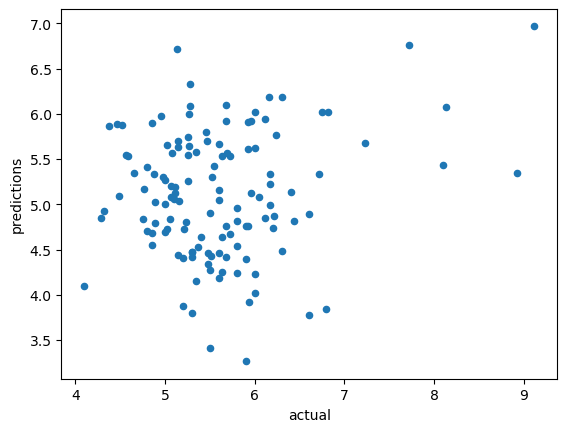

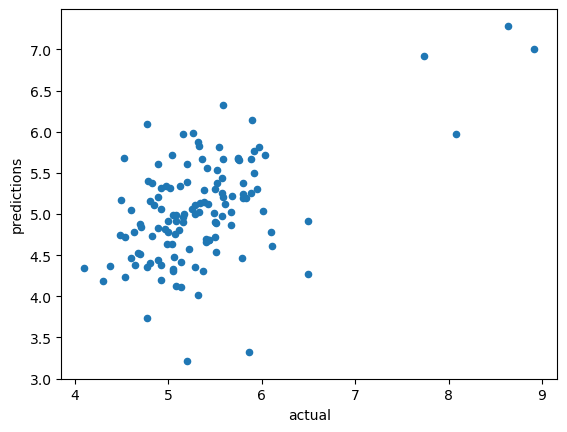

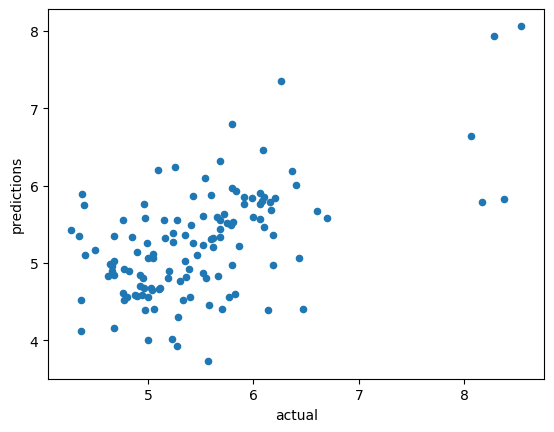

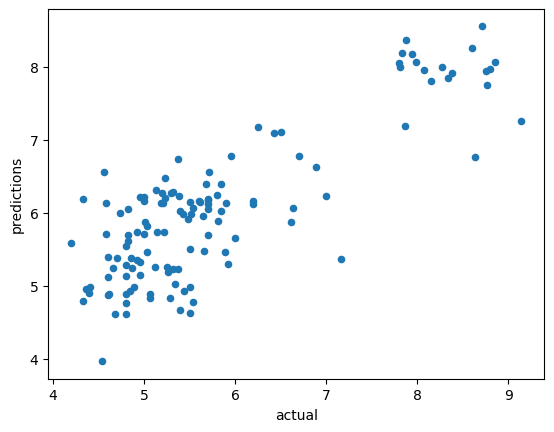

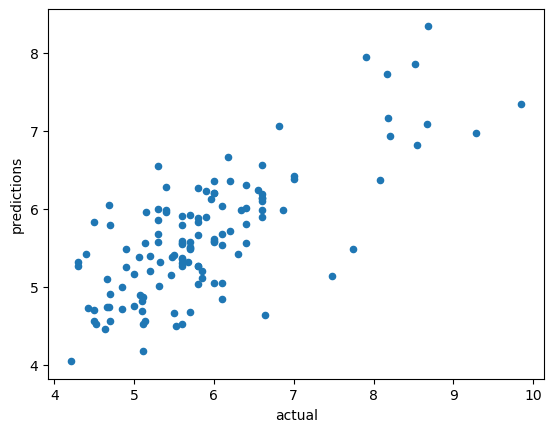

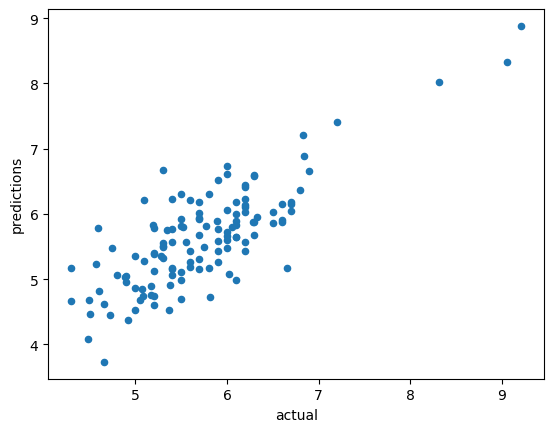

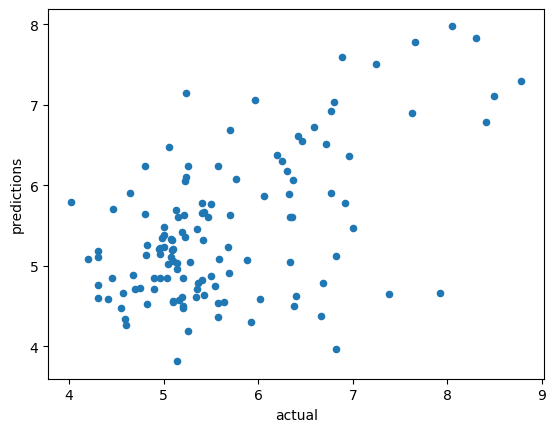

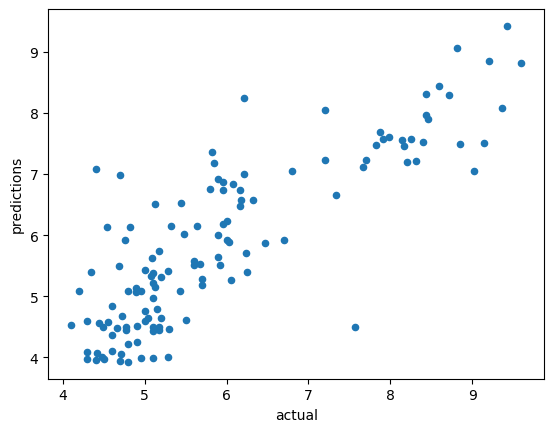

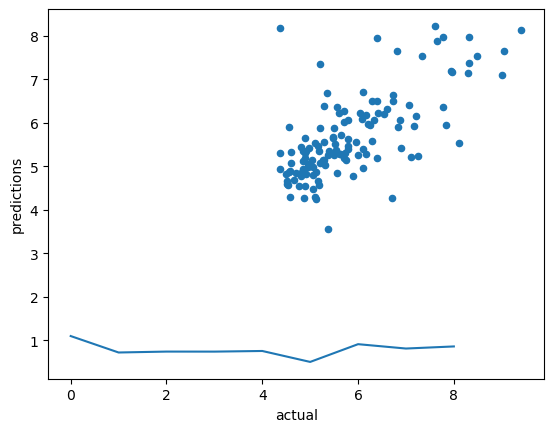

[1.0986679921426112, 0.7207094569410917, 0.7416051101566546, 0.7408587706273198, 0.7555153495341093, 0.5040261661875636, 0.9118925518796483, 0.8117856664516832, 0.8599234861073228]


In [14]:
plt.plot(rmse)
plt.show()
print(rmse)

In [15]:
def plot_graphs(data, results_df):
    
    results_df =pd.merge(data, results_df, 
                         left_on="Standardized_SMILES", right_on="Standardized_SMILES")
    
    # Calculate absolute errors and adjust results
    results_df['Error'] = (results_df['True Values'] - results_df['Predictions']).abs().round(2)
    results_df['True Values'] = results_df['True Values'].round(2)
    results_df['Predictions'] = results_df['Predictions'].round(2)

    # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['MolWt'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By MolWt')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
        # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['QED'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By QED')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['LogP'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By LogP')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()
    
     # Plotting
    plt.figure(figsize=(15, 6))
    plt.scatter(results_df['pchembl_value'], results_df['Error'], color='blue', marker='o', s=15)
    plt.xlabel('Sorted By IC50 Sorted')
    plt.ylabel('Absolute Error')
    plt.xticks(rotation=45)  # Optional: Improve readability of x-axis labels
    plt.grid(True)  # Optional: Adds grid lines for better readability
    plt.show()

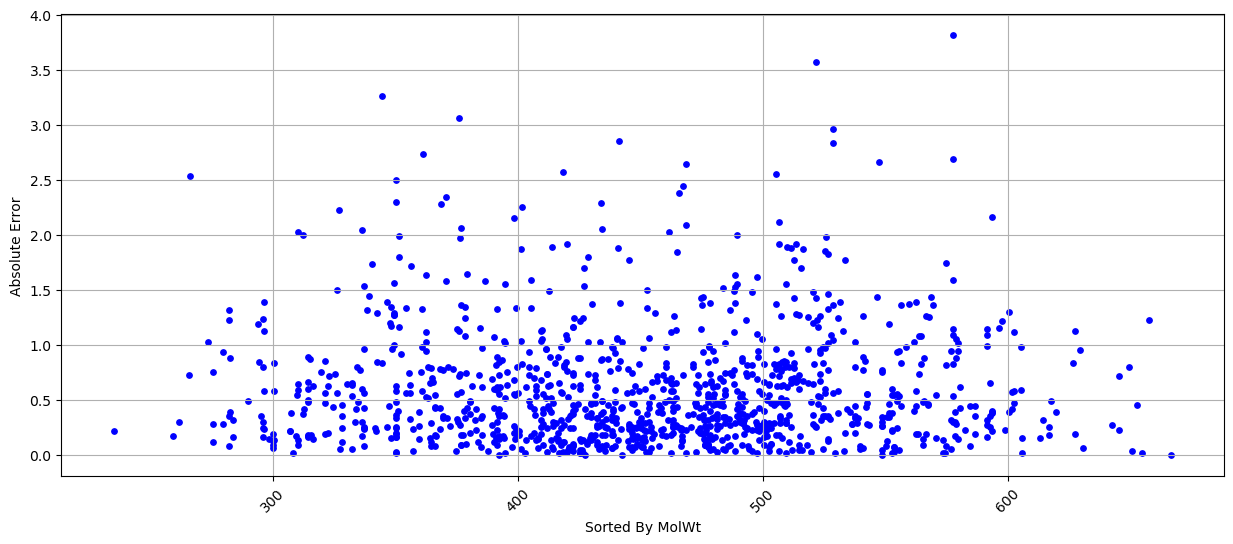

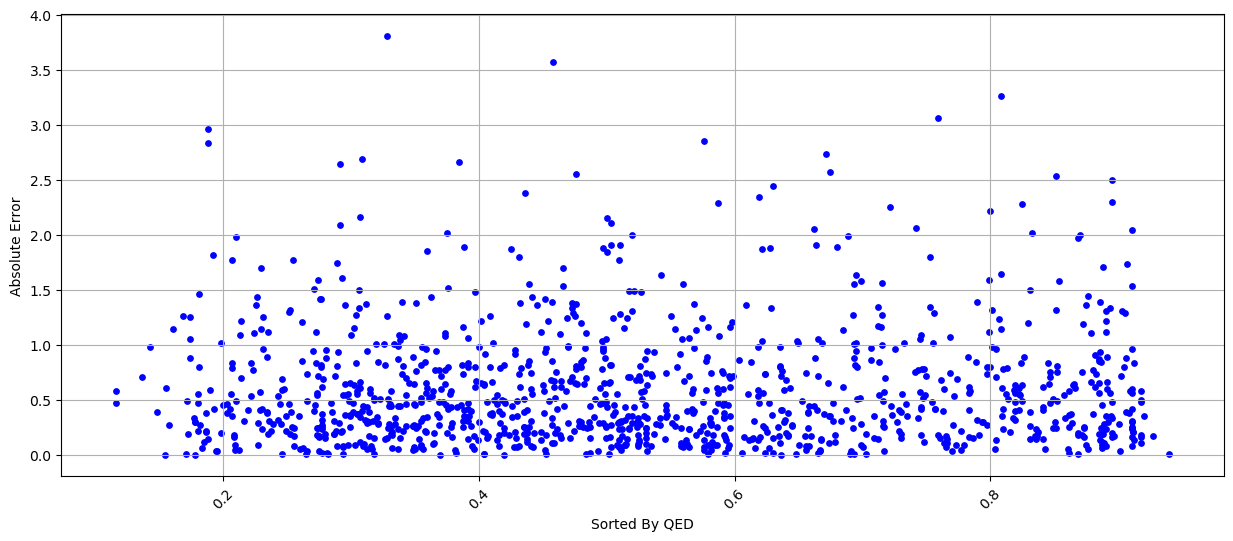

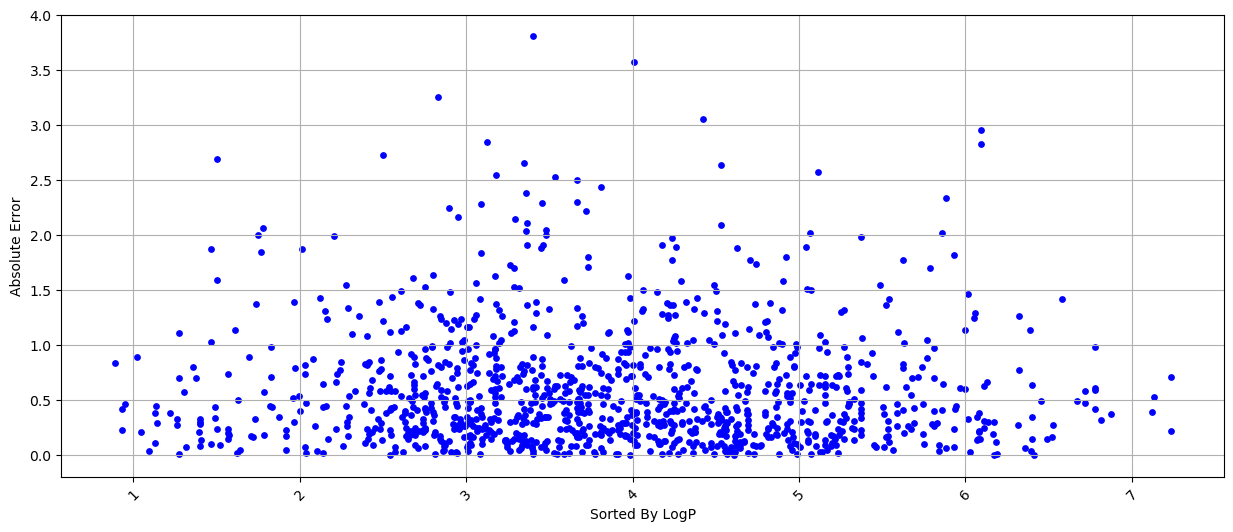

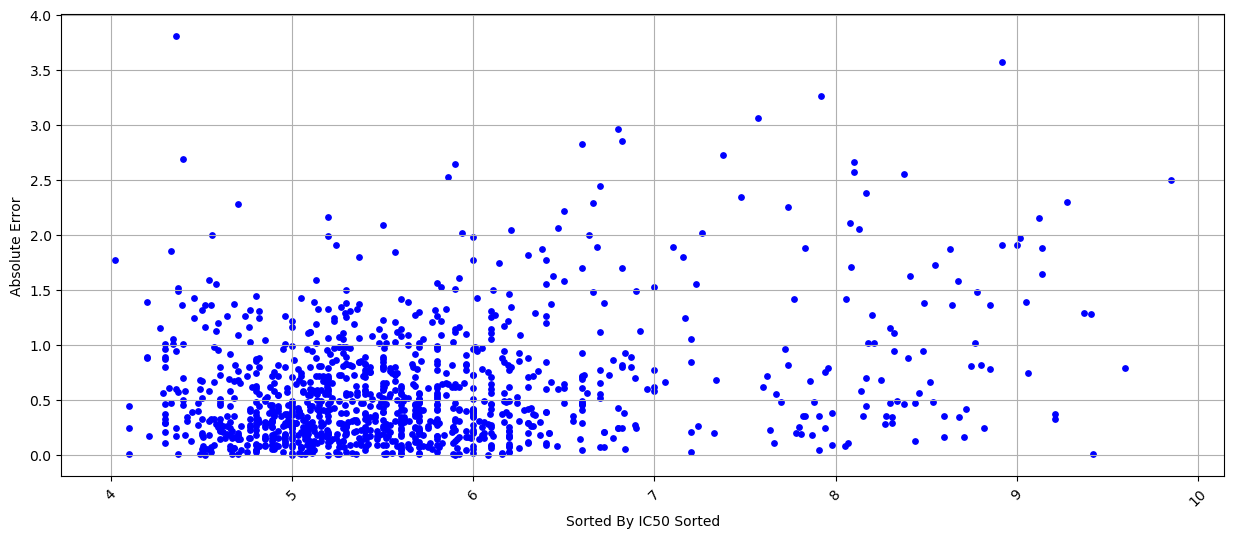

In [16]:
plot_graphs(df, results_df)

In [17]:
import random
df_copy=df.copy().sort_values(by="QED")#regular sort 
df_copy.plot(y="pchembl_value",use_index=False) #probabilities of each molecule being selected upon random selection without replacement
df_copy.plot(y="QED",use_index=False)

indices=df.nlargest(round(len(X)/10), ['QED']).index
X_test=X.copy()[indices]
y_test=y.copy()[indices]
smiles_test=smiles[indices]

X1=np.delete(X.copy(),indices,axis=0)
y1=np.delete(y.copy(),indices,axis=0)
smiles1=np.delete(smiles.copy(),indices,axis=0)


#X[df.nlargest(126, ['QED']).index].shape

In [18]:
#Calculating Discovery metrics on most drug-like candidates

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

def perform_fcv_on_most_druglike(X, y, smiles, k=10, sort_by=None, additional_info=None):
    false_discovery=list()
    true_discovery=list()
    true_ignore=list()
    false_ignore=list()
    rmse=list()
    train_df=pd.DataFrame()
    test_df=pd.DataFrame()
    if sort_by is not None:
        idx = np.argsort(sort_by)
        X, y, smiles = X[idx], y[idx], [smiles[i] for i in idx]
        if additional_info is not None:
            additional_info = [additional_info[i] for i in idx]


    predictions_all = []  # List to store all predictions
    true_values_all = []  # List to store all true values
    smiles_all = []       # List to store SMILES for each test sample
    sort_by_all = []      # List to store sort_by values for each test sample

    total_samples = len(X)
    fold_size = total_samples // k
    remainder = total_samples % k
    threshold=0
    for i in range(k-1):
        start = (i+1) * fold_size
        stop = ((i+1) + 1) * fold_size if (i+2) < k else total_samples
        
        X_train = np.vstack([X[:start]])
        y_train = np.concatenate([y[:start]])
        

        sort_by_test = additional_info[start:stop] if additional_info is not None else y[start:stop]
        
        model = nn.MLPRegressor(hidden_layer_sizes=(min(25,round(np.sqrt(X_train.shape[0])),)), random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print(stats.pearsonr(y_test, predictions))
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})
        discoveries.plot.scatter(x="actual",y="predictions",)#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions<@threshold")
        falses=discoveries.query("actual>@threshold")
        trues=discoveries.query("actual<@threshold")
        
        false_discovery.append(falses)
        true_discovery.append(trues)
        
        discoveries=pd.DataFrame({'Standardized_SMILES': smiles_test,'actual':y_test ,'predictions':predictions})#gonna subset this
        threshold=5.2 #previous max; discoveries defined as those who are predicted to be more than this
        discoveries=discoveries.query("predictions>@threshold")
        
        falses=discoveries.query("actual<@threshold")
        trues=discoveries.query("actual>@threshold")
        
        false_ignore.append(falses)
        true_ignore.append(trues)
        
        rmse.append(np.sqrt(mean_squared_error(y_test, predictions))) 
        smiles_train=np.concatenate([smiles[:start]])
        training_df=pd.DataFrame({
            'Standardized_SMILES': smiles_train,
        'True Values': y_train,
        'Predictions': model.predict(X_train)
        })
        
        training_df.insert(0,'training batch',(i+1))
        train_df=pd.concat([train_df,training_df]).reset_index(drop=True)
        testing_df=pd.DataFrame({
            'Standardized_SMILES': smiles_test,
        'True Values': y_test,
        'Predictions': predictions
        })
        testing_df.insert(0,'testing batch',(i+1))
        test_df=pd.concat([test_df,testing_df]).reset_index(drop=True)
        
        
        
        predictions_all.extend(predictions.tolist())
        true_values_all.extend(y_test.tolist())
        smiles_all.extend(smiles_test)
        sort_by_all.extend(sort_by_test)

    
    # Saving to CSV (optional)
    train_df.to_csv("unsorted_fcv_results_MLP_training batches_druglike.csv", index=False)
    test_df.to_csv("unsorted_fcv_results_MLP_testing batches_druglike.csv", index=False)
    results_df = pd.DataFrame({
        'Standardized_SMILES': smiles_all,
        'True Values': true_values_all,
        'Predictions': predictions_all,
        
    })


    # Return the DataFrame for further use or analysis
    return results_df,false_discovery,true_discovery, true_ignore, false_ignore,rmse

In [19]:


results_df2, false_disc2, true_disc2, true_ignore2, false_ignore2,rmse = perform_fcv_on_most_druglike(X1, y1, smiles1, sort_by=None, additional_info=df["QED"])

/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7495303805567205, 5.7658229480180994e-24)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7410952186970513, 3.3680251301170156e-23)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.6824140312993511, 1.379352925113758e-18)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7408325634731433, 3.5543902849687006e-23)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7422027907014442, 2.6818404096646413e-23)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.7999231970904395, 2.814041686531297e-29)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.8006175114094892, 2.321370859024827e-29)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.8012680889213644, 1.936975878125097e-29)


/home/jupyter-seal@broadinstitut-41f01/.local/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(0.8183701307117706, 1.2871608374323149e-31)


In [20]:
for i in np.arange(len(true_disc2)):
    print(true_disc2[i].shape)

(46, 3)
(41, 3)
(33, 3)
(40, 3)
(37, 3)
(32, 3)
(29, 3)
(31, 3)
(29, 3)


In [21]:
for i in np.arange(len(true_disc2)):
    print(false_disc2[i].shape)

(49, 3)
(26, 3)
(17, 3)
(20, 3)
(21, 3)
(13, 3)
(14, 3)
(12, 3)
(9, 3)


In [22]:
for i in np.arange(len(true_disc2)):
    print(true_ignore2[i].shape)

(28, 3)
(51, 3)
(60, 3)
(57, 3)
(56, 3)
(64, 3)
(63, 3)
(65, 3)
(68, 3)


In [23]:
for i in np.arange(len(true_disc2)):
    print(false_ignore2[i].shape)

(2, 3)
(7, 3)
(15, 3)
(8, 3)
(11, 3)
(16, 3)
(19, 3)
(17, 3)
(19, 3)


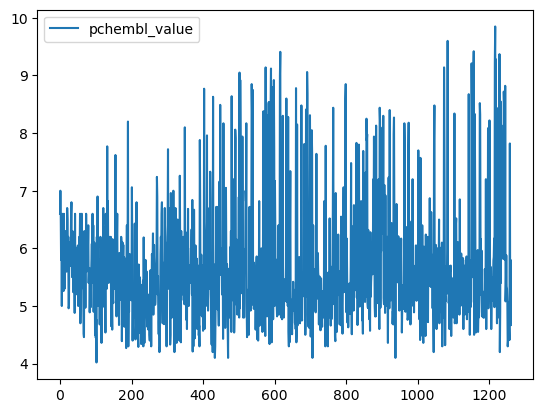

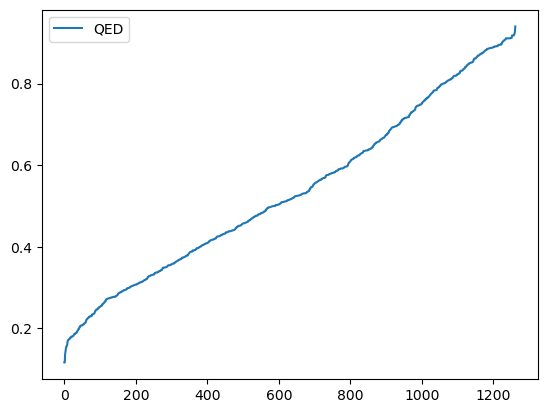

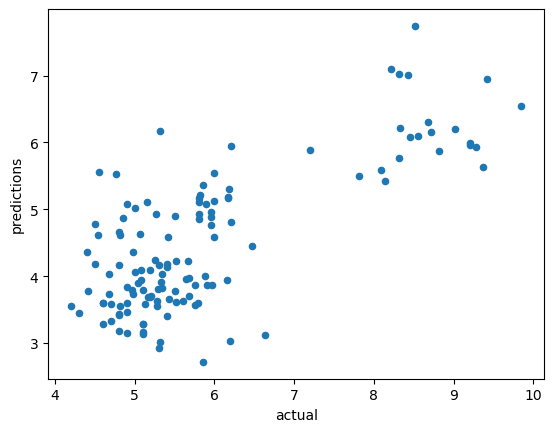

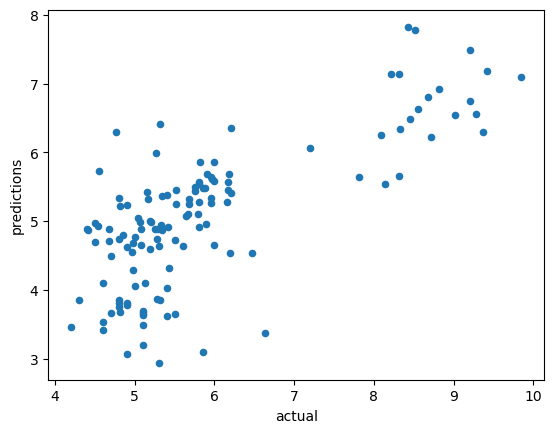

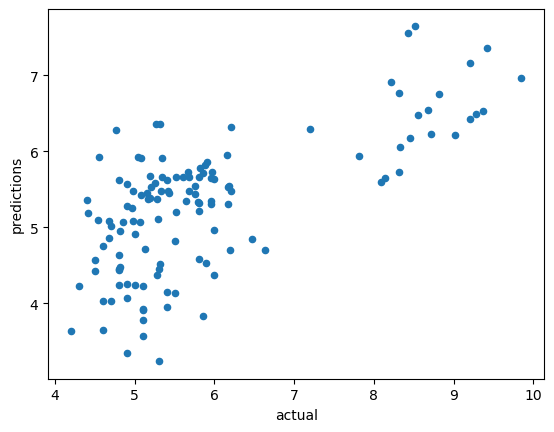

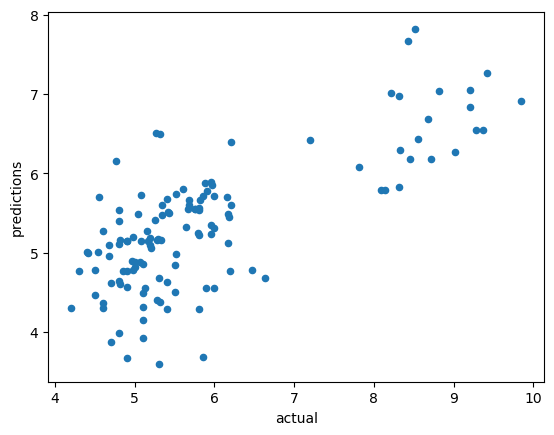

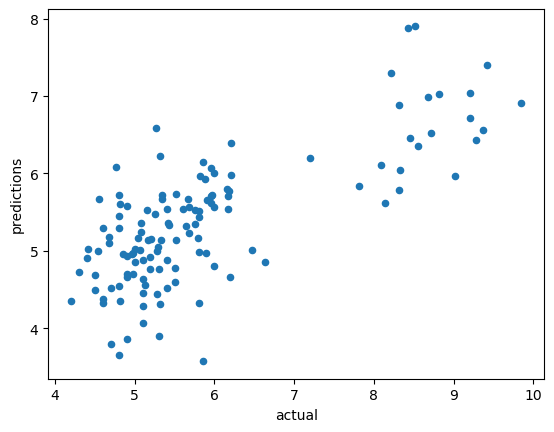

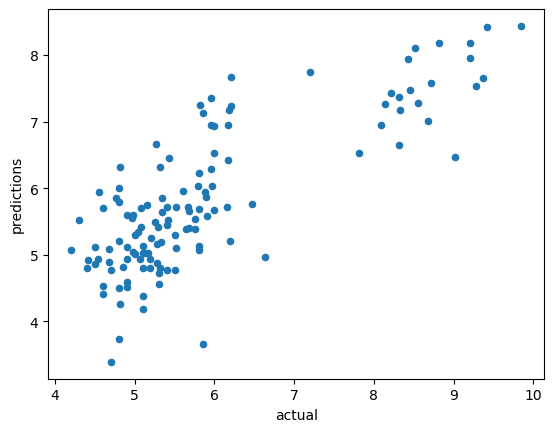

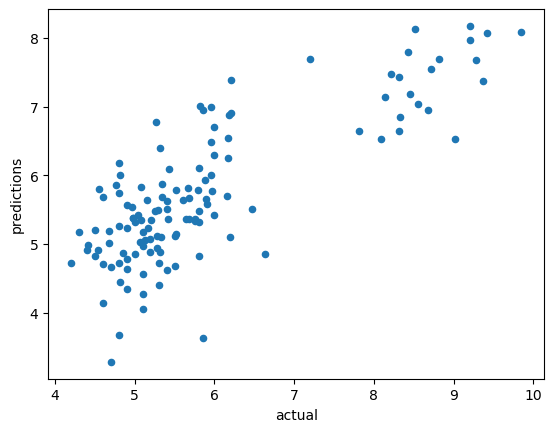

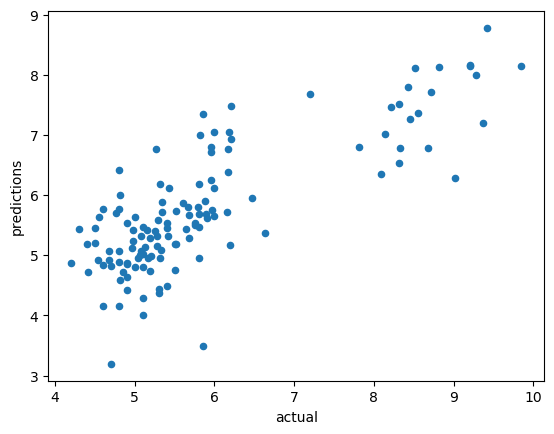

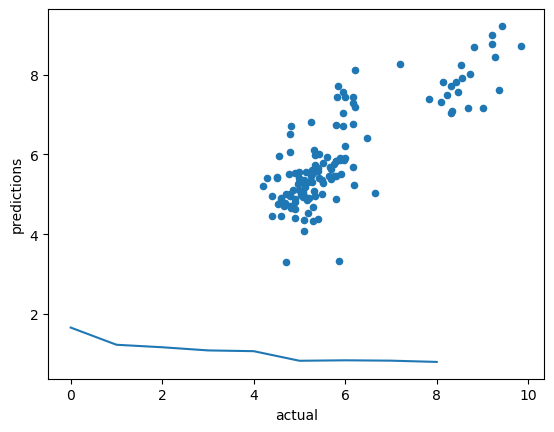

[1.6612484981908315, 1.2302129229572745, 1.1673432761673124, 1.0883999715192423, 1.0691756612080077, 0.8287546011075246, 0.8405147562322036, 0.831425855216464, 0.7998067593398832]


In [24]:
plt.plot(rmse)
plt.show()
print(rmse)